In [1]:
import torch
import torchvision

print(torch.__version__)
print(torchvision.__version__)

2.2.1+cu121
0.17.1+cu121


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [4]:

from torchvision.datasets import ImageFolder
from torchvision.transforms import v2

transforms = v2.Compose([
    v2.Resize((224,224)),
    v2.RandomHorizontalFlip(),
    # v2.ToDtype(torch.float32, scale=True)
    # v2.PILToTensor()
    v2.ToTensor()
])

data = ImageFolder(root="/content/drive/MyDrive/hj/Train", transform=transforms)
data, data.classes


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/v2/_deprecated.py:41: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(


(Dataset ImageFolder
     Number of datapoints: 409
     Root location: /content/drive/MyDrive/hj/Train
     StandardTransform
 Transform: Compose(
                  Resize(size=[224, 224], interpolation=InterpolationMode.BILINEAR, antialias=True)
                  RandomHorizontalFlip(p=0.5)
                  ToTensor()
            ),
 ['Daljit', 'Japanese model'])

In [5]:
class_names = data.classes
class_names

['Daljit', 'Japanese model']

In [6]:
from torch.utils.data import Subset

data_len = len(data)
# small_data_len = data_len - int(0.70 * data_len)
# print(small_data_len)
n_test = int(0.30 * data_len)
print(n_test)
test_data = Subset(data, range(n_test))
train_data = Subset(data, range(n_test, data_len))
len(train_data), len(test_data)

122


(287, 122)

In [7]:
import os
from torch.utils.data import DataLoader
BATCH_SIZE = 32
NUM_WORKERS = 8
train_dataloader = DataLoader(dataset=train_data,
                              batch_size=BATCH_SIZE,
                              shuffle=True,
                              num_workers=NUM_WORKERS,
                              drop_last=True)

test_dataloader = DataLoader(dataset=test_data,
                             batch_size=BATCH_SIZE,
                             num_workers=NUM_WORKERS,
                             drop_last=True)

len(train_dataloader), len(test_dataloader), class_names

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


(8, 3, ['Daljit', 'Japanese model'])

torch.Size([3, 224, 224]) tensor(1)


(-0.5, 223.5, 223.5, -0.5)

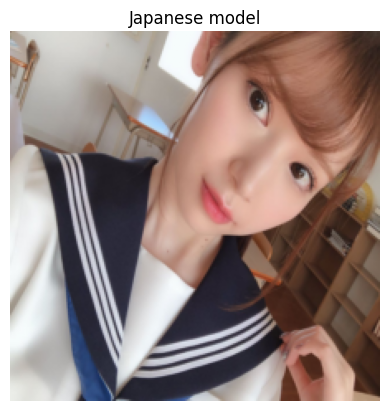

In [14]:

from matplotlib import pyplot as plt
img_batch, label_batch = next(iter(train_dataloader))
img, label = img_batch[0], label_batch[0]
print(img.shape, label)
plt.imshow(img.permute(1,2,0))
plt.title(class_names[label])
plt.axis(False)

In [15]:

# calculating input shapes(no. of patches)
height = 224
width = 224
color_channels = 3
patch_size = 16

num_patches = int((height*width)/patch_size**2)
num_patches


196

In [16]:
embedding_layer_input_shape = (height, width, color_channels)

embedding_layer_output_shape = (num_patches, patch_size**2*color_channels)

print(f"Input shape (single 2d image): {embedding_layer_input_shape}")
print(f"Output shape (single 1d sequence of patches): {embedding_layer_output_shape}")

Input shape (single 2d image): (224, 224, 3)
Output shape (single 1d sequence of patches): (196, 768)


In [17]:
img.shape

torch.Size([3, 224, 224])

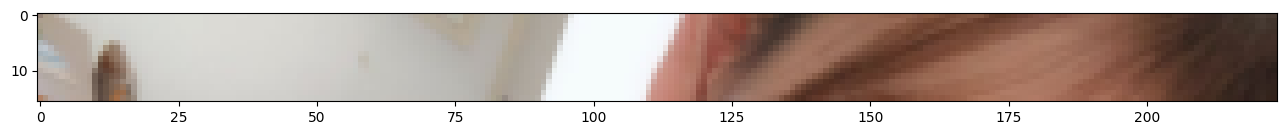

In [18]:
image_permuted = img.permute(1,2,0)
patch_size = 16
plt.figure(figsize=(patch_size, patch_size))
plt.imshow(image_permuted[:patch_size, :, :])

Number of patches per row=14.0
Patch size: 16 pixels x 16 pixels


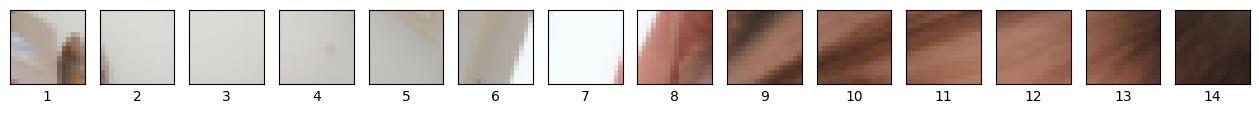

In [19]:
img_size = 224
patch_size = 16
num_patches = img_size/patch_size
assert img_size % patch_size == 0, "Image size must be divisible by patch_size"
print(f"Number of patches per row={num_patches}\nPatch size: {patch_size} pixels x {patch_size} pixels")
# plt.figure(figsize=(16,16))
fig, axs = plt.subplots(nrows=1,
                        ncols=img_size // patch_size,
                        sharex=True,
                        sharey=True,
                        figsize=(patch_size, patch_size))

for i, patch in enumerate(range(0, img_size, patch_size)):
  axs[i].imshow(image_permuted[:patch_size, patch:patch+patch_size,:])
  axs[i].set_xlabel(i+1)
  axs[i].set_xticks([])
  axs[i].set_yticks([])

Number of patches per row: 14.0
Number of patches per column: 14.0
Total patches: 196.0
Patch size: 16 pixels x 16 pixels


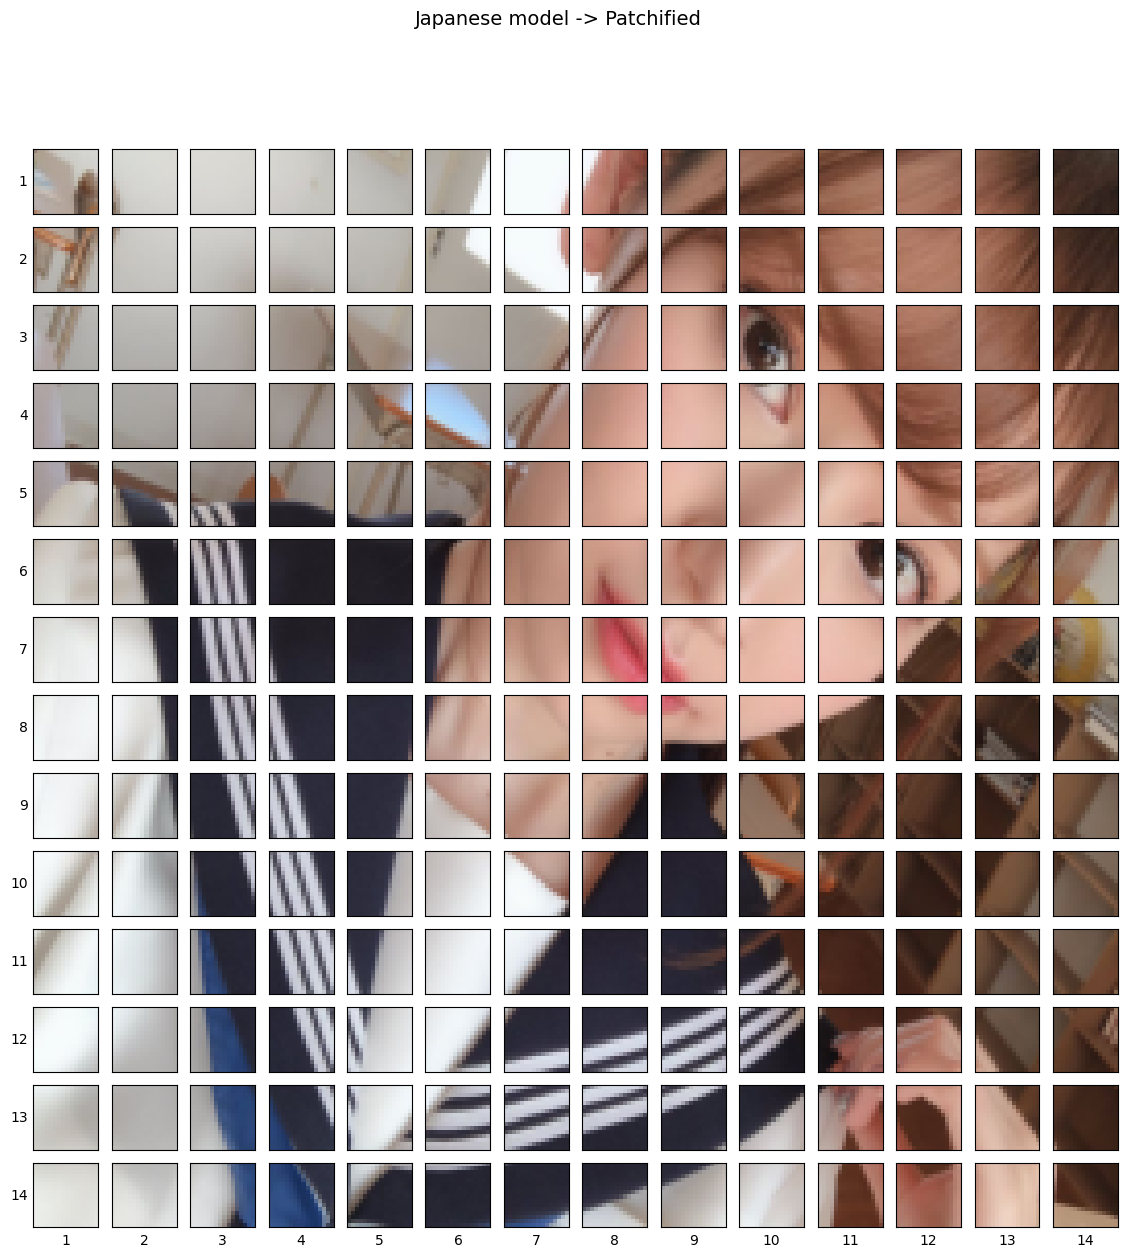

In [20]:
img_size = 224
patch_size = 16
num_patches = img_size/patch_size
assert img_size % patch_size == 0, "Image size must be divisible by patch size"
print(f"Number of patches per row: {num_patches}\
\nNumber of patches per column: {num_patches}\
\nTotal patches: {num_patches*num_patches}\
\nPatch size: {patch_size} pixels x {patch_size} pixels")

fig, axs = plt.subplots(nrows=img_size // patch_size,
                        ncols=img_size//patch_size,
                        figsize=(num_patches, num_patches),
                        sharex=True,
                        sharey=True)

for i, patch_height in enumerate(range(0, img_size, patch_size)):
  for j, patch_width in enumerate(range(0, img_size, patch_size)):
    axs[i, j].imshow(image_permuted[patch_height:patch_height+patch_size,
                                    patch_width:patch_width+patch_size,
                                    :])
    axs[i, j].set_ylabel(i+1,
                         rotation='horizontal',
                         horizontalalignment="right",
                         verticalalignment='center')
    axs[i, j].set_xlabel(j+1)
    axs[i, j].set_xticks([])
    axs[i, j].set_yticks([])
    axs[i, j].label_outer()

fig.suptitle(f"{class_names[label]} -> Patchified", fontsize=14)
fig.show()

In [21]:
from torch import nn

patch_size = 16

conv2d = nn.Conv2d(in_channels=3,
                   out_channels=768,
                   kernel_size=patch_size,
                   stride=patch_size,
                   padding=0)
conv2d

Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))

(-0.5, 223.5, 223.5, -0.5)

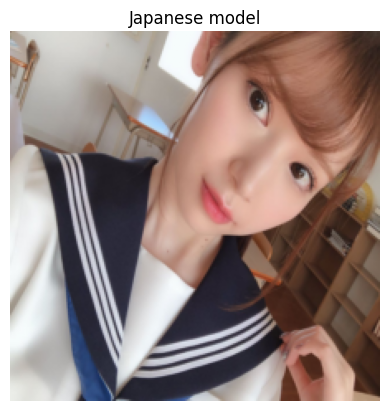

In [22]:
plt.imshow(img.permute(1,2,0))
plt.title(class_names[label])
plt.axis(False)

In [23]:

image_out_of_conv = conv2d(img.unsqueeze(0))
image_out_of_conv.shape

torch.Size([1, 768, 14, 14])

Showing random convulutional maps from random indexes: [330, 215, 320, 635, 496]


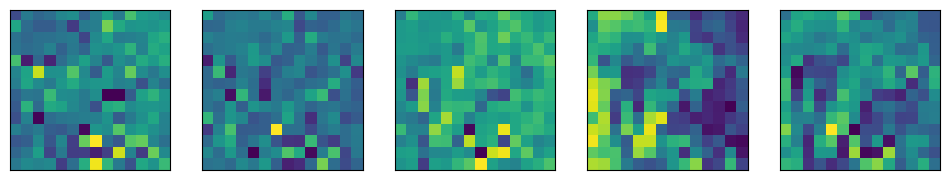

In [24]:
import random
random_indexes = random.sample(range(0, 768),k=5)
print(f"Showing random convulutional maps from random indexes: {random_indexes}")

fig, axs = plt.subplots(nrows=1, ncols=5, figsize=(12,12))

for i, idx in enumerate(random_indexes):
  image_conv_feature_map = image_out_of_conv[:, idx, :, :]
  axs[i].imshow(image_conv_feature_map.squeeze().detach().numpy())
  axs[i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])


In [25]:
flatten = nn.Flatten(start_dim=2, end_dim=3)

Original image shape: torch.Size([3, 224, 224])
image feature map (patches shape): torch.Size([1, 768, 14, 14])
Flattened image feature map shape: torch.Size([1, 768, 196])


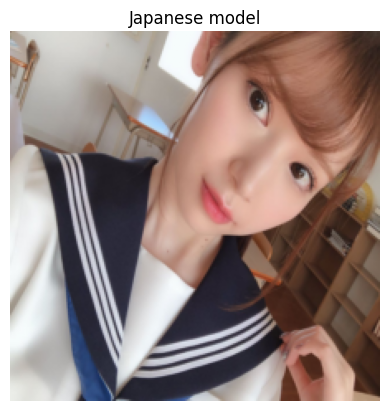

In [26]:

plt.imshow(img.permute(1, 2, 0))
plt.title(class_names[label])
plt.axis(False)
print(f"Original image shape: {img.shape}")

image_out_of_conv = conv2d(img.unsqueeze(0))
print(f"image feature map (patches shape): {image_out_of_conv.shape}")

image_out_of_conv_flattened = flatten(image_out_of_conv)
print(f"Flattened image feature map shape: {image_out_of_conv_flattened.shape}")

In [27]:
# Rearrage outpupt of flattened layer
image_out_reshaped = image_out_of_conv_flattened.permute(0, 2, 1)
image_out_reshaped.shape

torch.Size([1, 196, 768])

(-0.5, 195.5, 0.5, -0.5)

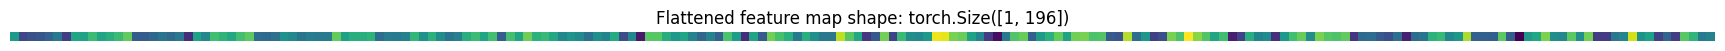

In [28]:
single_flattened_feature_map = image_out_reshaped[:,:,0]
plt.figure(figsize=(22,22))
plt.imshow(single_flattened_feature_map.detach().numpy())
plt.title(f"Flattened feature map shape: {single_flattened_feature_map.shape}")
plt.axis(False)

In [29]:
class PatchEmbedding(nn.Module):
  def __init__(self,
               in_channels:int=3,
               patch_size:int=16,
               embedding_dim:int=768,
               batch_size:int=1,
               img_height:int=224,
               img_width:int=224):
    super().__init__()
    self.num_patches = int((img_height*img_width)/patch_size**2)
    self.class_token = nn.Parameter(torch.randn(batch_size,
                                                1,
                                                embedding_dim),
                           requires_grad=True)
    self.pos_embedding = nn.Parameter(torch.randn(batch_size,
                                                 self.num_patches+1,
                                                 embedding_dim),
                                      requires_grad=True)
    self.img_embedding_layer = nn.Sequential(
    nn.Conv2d(in_channels=in_channels,
              out_channels=embedding_dim,
              kernel_size=patch_size,
              stride=patch_size,
              padding=0),
    nn.Flatten(start_dim=2,
               end_dim=3))
  def forward(self, x):
    image_resolution = x.shape[-1]
    assert image_resolution % patch_size == 0, f"Input image size {image_resolution} must be divisible by patch size {patch_size}"
    x = self.img_embedding_layer(x)
    x = x.permute(0,2,1)
    x = torch.cat((self.class_token, x), dim=1)
    x = self.pos_embedding + x
    return x

patchify = PatchEmbedding()
patch_embedded_image = patchify(img.unsqueeze(0))
patch_embedded_image.shape

torch.Size([1, 197, 768])

In [30]:
class MultiHeadSelfAttentionBlock(nn.Module):
  def __init__(self,
               embedding_dim:int=768,
               num_heads:int=12,
               attn_dropout:int=0):
    super().__init__()
    self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)
    self.multihead_attn = nn.MultiheadAttention(embed_dim=embedding_dim,
                                     num_heads=num_heads,
                                     dropout=attn_dropout,
                                     batch_first=True)
  def forward(self, x):
    residual = x
    x = self.layer_norm(x)
    attn_output, _ = self.multihead_attn(query=x,
                                          key=x,
                                          value=x,
                                          need_weights=False)
    # x = attn_output + residual
    return attn_output
image_msa_output = MultiHeadSelfAttentionBlock()
msa_output = image_msa_output(patch_embedded_image)
msa_output.shape

torch.Size([1, 197, 768])

In [31]:

class MLPBlock(nn.Module):
  def __init__(self,
               embedding_dim:int=768,
               mlp_size:int=3072,
               dropout:int=0.1):
    super().__init__()
    self.layer_1 = nn.Linear(in_features=embedding_dim,
                             out_features=mlp_size)
    self.gelu = nn.GELU()
    self.dropout = nn.Dropout(p=dropout)
    self.layer_2 = nn.Linear(in_features=mlp_size,
                             out_features=embedding_dim)
    self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)
  def forward(self, x):
    x = self.layer_norm(x)
    x = self.layer_1(x)
    x = self.gelu(x)
    x = self.dropout(x)
    x = self.layer_2(x)
    x = self.dropout(x)
    return x
mlp_layer = MLPBlock()
mlp_output = mlp_layer(msa_output)
mlp_output.shape

torch.Size([1, 197, 768])

In [33]:
class TransformerEndcoderBlock(nn.Module):
  def __init__(self,
               embedding_dim:int=768,
               num_heads:int=12,
               mlp_size:int=3072,
               mlp_dropout:int=0.1,
               attn_dropout:int=0):
    super().__init__()
    self.msa_block = MultiHeadSelfAttentionBlock(embedding_dim=embedding_dim,
                                                 num_heads=num_heads,
                                                 attn_dropout=attn_dropout)

    self.mlp_block = MLPBlock(embedding_dim=embedding_dim,
                              mlp_size=mlp_size,
                              dropout=mlp_dropout)

  def forward(self, x):
    x = self.msa_block(x) + x
    x = self.mlp_block(x) + x
    return x

In [34]:
transformer_block = TransformerEndcoderBlock()
def model_summary(model:torch.nn.Module,
                  input_size:tuple):
  try:
    from torchinfo import summary
  except:
    !pip install torchinfo
    from torchinfo import summary

  return summary(model=model,
                input_size=input_size,
                col_names=["input_size", "output_size", "num_params", "trainable"],
                col_width=20,
                row_settings=['var_names'])

model_summary(model=transformer_block,
              input_size=(1,197,768))

Layer (type (var_name))                                 Input Shape          Output Shape         Param #              Trainable
TransformerEndcoderBlock (TransformerEndcoderBlock)     [1, 197, 768]        [1, 197, 768]        --                   True
├─MultiHeadSelfAttentionBlock (msa_block)               [1, 197, 768]        [1, 197, 768]        --                   True
│    └─LayerNorm (layer_norm)                           [1, 197, 768]        [1, 197, 768]        1,536                True
│    └─MultiheadAttention (multihead_attn)              --                   [1, 197, 768]        2,362,368            True
├─MLPBlock (mlp_block)                                  [1, 197, 768]        [1, 197, 768]        --                   True
│    └─LayerNorm (layer_norm)                           [1, 197, 768]        [1, 197, 768]        1,536                True
│    └─Linear (layer_1)                                 [1, 197, 768]        [1, 197, 3072]       2,362,368            True
│  

In [35]:
# Creating a transformer encoder layer with in-built PyTorch layers

torch_transformer_encoder_layer = nn.TransformerEncoderLayer(d_model=768,
                                                             nhead=12,
                                                             dim_feedforward=3072,
                                                             dropout=0.1,
                                                             activation="gelu",
                                                             batch_first=True,
                                                             norm_first=True,
                                                             device=device)

model_summary(model=torch_transformer_encoder_layer,
              input_size=(1,197,768))

Layer (type (var_name))                            Input Shape          Output Shape         Param #              Trainable
TransformerEncoderLayer (TransformerEncoderLayer)  [1, 197, 768]        [1, 197, 768]        7,087,872            True
Total params: 7,087,872
Trainable params: 7,087,872
Non-trainable params: 0
Total mult-adds (M): 0
Input size (MB): 0.61
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.61

In [36]:
class ViTModel(nn.Module):
  def __init__(self,
               batch_size:int=32,
               img_size:int=224,
               patch_size:int=16,
               in_channels:int=3,
               num_transformer_layers=12,
               embedding_dim:int=768,
               num_heads:int=12,
               attn_dropout:float=0.1,
               mlp_dropout:float=0.1,
               device:torch.device=device,
               mlp_size:int=3072,
               num_classes:int=1000):
      super().__init__()

      self.patch_embeddings = PatchEmbedding(in_channels=in_channels,
                                             patch_size=16,
                                             embedding_dim=embedding_dim,
                                             batch_size=batch_size,
                                             img_height=img_size,
                                             img_width=img_size)

      self.transformer_encoder = nn.Sequential(*[nn.TransformerEncoderLayer(d_model=embedding_dim,
                                                             nhead=num_heads,
                                                             dim_feedforward=mlp_size,
                                                             dropout=attn_dropout,
                                                             activation="gelu",
                                                             batch_first=True,
                                                             norm_first=True,
                                                             device=device) for _ in range(num_transformer_layers)])
      self.classifier = nn.Sequential(
          nn.LayerNorm(normalized_shape=embedding_dim),
          nn.Linear(in_features=embedding_dim, out_features=num_classes)
      )
  def forward(self, x):
    x = self.patch_embeddings(x)
    x = self.transformer_encoder(x)
    x = self.classifier(x[:,0])
    return x


In [37]:
model_0 = ViTModel(batch_size=32,
                   num_classes=2).to(device)
input_size = (32, 3, 224, 224)
model_summary(model=model_0,
              input_size=input_size)

Layer (type (var_name))                       Input Shape          Output Shape         Param #              Trainable
ViTModel (ViTModel)                           [32, 3, 224, 224]    [32, 2]              --                   True
├─PatchEmbedding (patch_embeddings)           [32, 3, 224, 224]    [32, 197, 768]       4,866,048            True
│    └─Sequential (img_embedding_layer)       [32, 3, 224, 224]    [32, 768, 196]       --                   True
│    │    └─Conv2d (0)                        [32, 3, 224, 224]    [32, 768, 14, 14]    590,592              True
│    │    └─Flatten (1)                       [32, 768, 14, 14]    [32, 768, 196]       --                   --
├─Sequential (transformer_encoder)            [32, 197, 768]       [32, 197, 768]       --                   True
│    └─TransformerEncoderLayer (0)            [32, 197, 768]       [32, 197, 768]       7,087,872            True
│    └─TransformerEncoderLayer (1)            [32, 197, 768]       [32, 197, 768]    

In [38]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_0.parameters(),
                             lr=0.001,
                             betas=(0.9, 0.999),
                             weight_decay=0.1)


In [39]:
try:
  from torchmetrics.classification import BinaryAccuracy as Accuracy
except:
  !pip install torchmetrics
  from torchmetrics.classification import BinaryAccuracy as Accuracy
accuracy = Accuracy().to(device)
def train_step(dataloader:torch.utils.data.DataLoader,
               model:torch.nn.Module,
               loss_fn:torch.nn,
               optimizer:torch.optim):
  model.train()
  train_loss, train_acc = 0, 0
  for batch, (X, y) in enumerate(dataloader):
    X, y = X.to(device), y.to(device)
    y_logits = model(X)
    y_preds = torch.argmax(torch.softmax(y_logits, dim=1), dim=1)
    loss = loss_fn(y_logits, y)
    train_loss += loss.item()
    acc = accuracy(y_preds, y)
    train_acc += acc
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
  train_loss = train_loss/len(dataloader)
  train_acc = train_acc/len(dataloader)

  return train_loss, train_acc


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 868.8/868.8 kB 11.0 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-man

In [40]:
def test_step(dataloader:torch.utils.data.DataLoader,
              model:torch.nn.Module,
              loss_fn:torch.nn):
  model.eval()
  test_loss, test_acc = 0,0
  with torch.inference_mode():
    for batch, (X, y) in enumerate(dataloader):
      X, y = X.to(device), y.to(device)
      test_logits = model(X)
      loss = loss_fn(test_logits, y)
      test_loss += loss.item()
      test_preds = torch.argmax(torch.softmax(test_logits,dim=1),dim=1)
      acc = accuracy(test_preds, y)
      test_acc += acc
  test_loss = test_loss / len(dataloader)
  test_acc = test_acc / len(dataloader)
  return test_loss, test_acc

In [41]:
from tqdm.auto import tqdm
def train(model:torch.nn.Module,
          train_dataloader:torch.utils.data.DataLoader,
          test_dataloader:torch.utils.data.DataLoader,
          loss_fn:torch.nn,
          optimizer:torch.optim,
          epochs:int):
  results = {
      "train_loss": [],
      "train_acc": [],
      "test_loss": [],
      "test_acc": []
  }
  for epoch in tqdm(range(epochs)):
    train_loss, train_acc = train_step(dataloader=train_dataloader,
                                      model=model,
                                      loss_fn=loss_fn,
                                      optimizer=optimizer)
    test_loss, test_acc = test_step(dataloader=test_dataloader,
                                    model=model,
                                    loss_fn=loss_fn)
    results['train_loss'].append(train_loss)
    results['train_acc'].append(train_acc)
    results['test_loss'].append(test_loss)
    results['test_acc'].append(test_acc)
    print(f"Epoch: {epoch} | Train Loss: {train_loss:.5f} | Train Accuracy: {train_acc:.2f}% | Test Loss: {test_loss:.5f} | Test Accuracy: {test_acc:.2f}%")
  return results

In [42]:
torch.cuda.empty_cache()

In [43]:
# Start the training
results = train(model=model_0,
                train_dataloader=train_dataloader,
                test_dataloader=test_dataloader,
                loss_fn=loss_fn,
                optimizer=optimizer,
                epochs=10)
results

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 0 | Train Loss: 1.81236 | Train Accuracy: 0.69% | Test Loss: 0.81274 | Test Accuracy: 0.21%
Epoch: 1 | Train Loss: 0.82581 | Train Accuracy: 0.57% | Test Loss: 1.60578 | Test Accuracy: 0.00%
Epoch: 2 | Train Loss: 0.74774 | Train Accuracy: 0.67% | Test Loss: 2.68403 | Test Accuracy: 0.00%
Epoch: 3 | Train Loss: 0.58313 | Train Accuracy: 0.70% | Test Loss: 2.24464 | Test Accuracy: 0.00%
Epoch: 4 | Train Loss: 0.48692 | Train Accuracy: 0.77% | Test Loss: 1.35163 | Test Accuracy: 0.01%
Epoch: 5 | Train Loss: 0.44252 | Train Accuracy: 0.75% | Test Loss: 1.67440 | Test Accuracy: 0.00%
Epoch: 6 | Train Loss: 0.39396 | Train Accuracy: 0.78% | Test Loss: 1.66694 | Test Accuracy: 0.00%
Epoch: 7 | Train Loss: 0.38761 | Train Accuracy: 0.78% | Test Loss: 1.71412 | Test Accuracy: 0.02%
Epoch: 8 | Train Loss: 0.37328 | Train Accuracy: 0.80% | Test Loss: 1.46026 | Test Accuracy: 0.04%
Epoch: 9 | Train Loss: 0.32777 | Train Accuracy: 0.88% | Test Loss: 1.31683 | Test Accuracy: 0.10%


{'train_loss': [1.8123595267534256,
  0.8258096240460873,
  0.7477404251694679,
  0.5831335410475731,
  0.4869243651628494,
  0.442524217069149,
  0.3939622566103935,
  0.3876056522130966,
  0.373275775462389,
  0.32777467742562294],
 'train_acc': [tensor(0.6914, device='cuda:0'),
  tensor(0.5703, device='cuda:0'),
  tensor(0.6680, device='cuda:0'),
  tensor(0.7031, device='cuda:0'),
  tensor(0.7734, device='cuda:0'),
  tensor(0.7500, device='cuda:0'),
  tensor(0.7773, device='cuda:0'),
  tensor(0.7773, device='cuda:0'),
  tensor(0.7969, device='cuda:0'),
  tensor(0.8828, device='cuda:0')],
 'test_loss': [0.8127354184786478,
  1.6057756741841633,
  2.684028387069702,
  2.2446378072102866,
  1.3516302903493245,
  1.6743961572647095,
  1.6669368743896484,
  1.7141229311625164,
  1.4602622985839844,
  1.3168333371480305],
 'test_acc': [tensor(0.2083, device='cuda:0'),
  tensor(0., device='cuda:0'),
  tensor(0., device='cuda:0'),
  tensor(0., device='cuda:0'),
  tensor(0.0104, device='cuda

In [44]:

def plot_loss_curves(results):

    # Get the loss values of the results dictionary (training and test)
    loss = results['train_loss']
    test_loss = results['test_loss']

    # Get the accuracy values of the results dictionary (training and test)
    accuracy = [tensor.cpu().numpy() for tensor in results['train_acc']]
    test_accuracy = [tensor.cpu().numpy() for tensor in results['test_acc']]

    # Figure out how many epochs there were
    epochs = range(len(results['train_loss']))

    # Setup a plot
    plt.figure(figsize=(15, 7))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label='train_loss')
    plt.plot(epochs, test_loss, label='test_loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label='train_accuracy')
    plt.plot(epochs, test_accuracy, label='test_accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend();

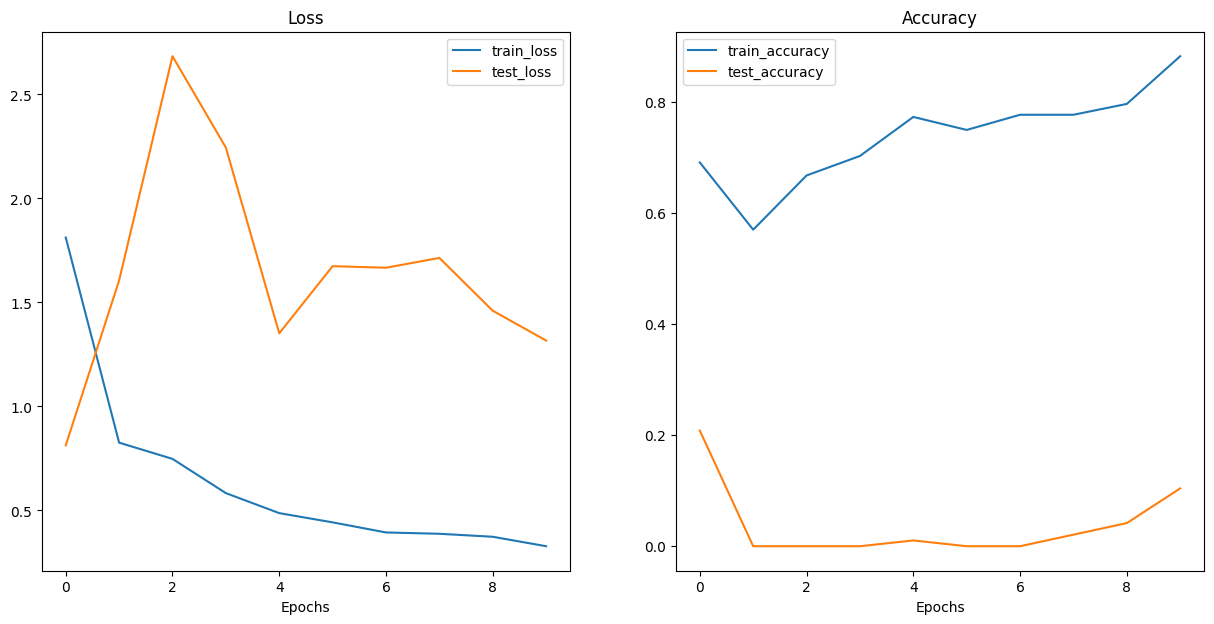

In [45]:
plot_loss_curves(results)

In [52]:
from PIL import Image
def img_to_tensor(img_path:str):
  test_img = Image.open(img_path)
  test_transform = v2.Compose([
      v2.Resize((224, 224)),
      v2.ToTensor()
  ])
  test_img_tensor = test_transform(test_img)
  if test_img_tensor.shape[0] != 3:
    test_img_tensor = test_img_tensor[:3, :, :]
  batched_image = test_img_tensor.unsqueeze(0).repeat(32, 1, 1, 1)
  print(batched_image.shape)
  return batched_image, test_img
fake_img_tensor, fake_img = img_to_tensor("/content/drive/MyDrive/hj/Train/Daljit/149.jpg")
real_img_tensor, real_img = img_to_tensor("/content/drive/MyDrive/hj/Train/Japanese model/IMG_20230507_021259_192.jpg")

torch.Size([32, 3, 224, 224])
torch.Size([32, 3, 224, 224])


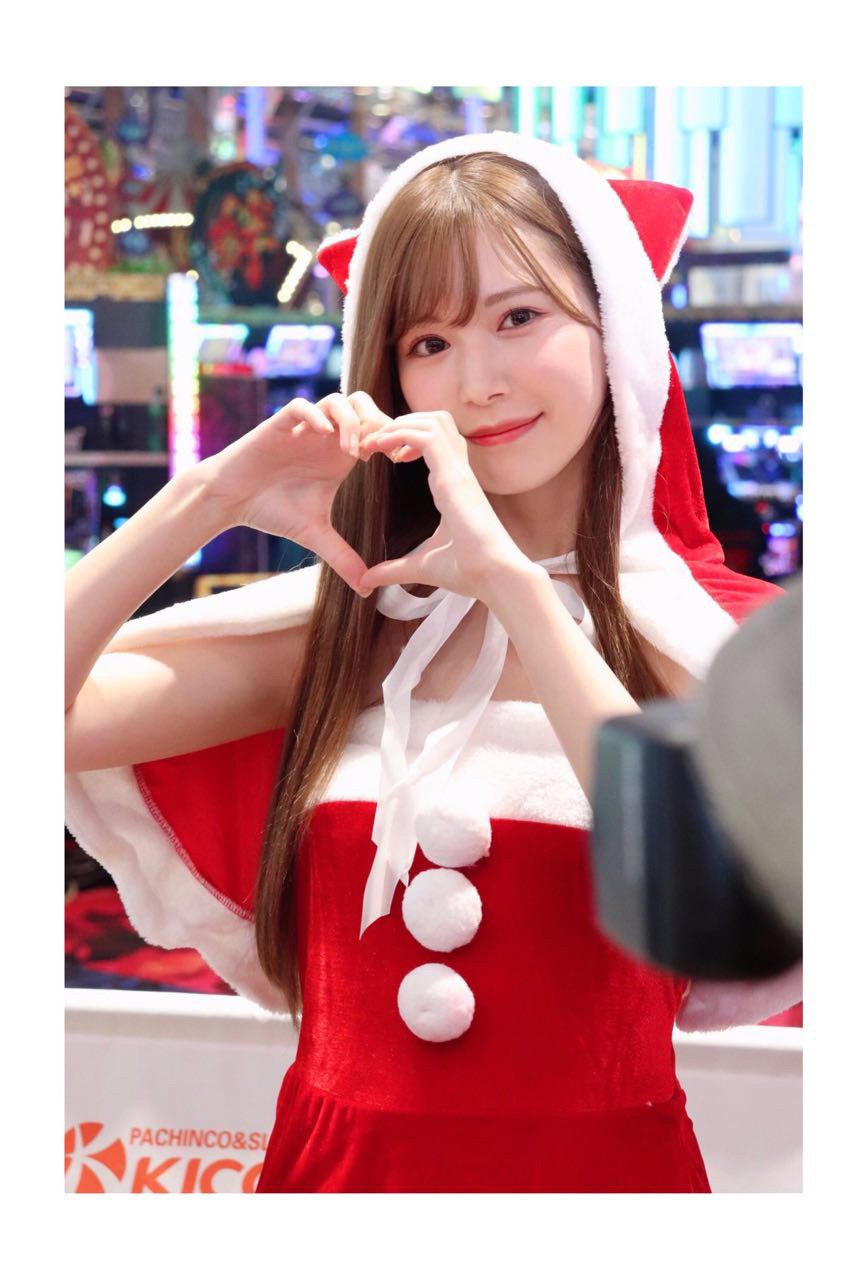

In [53]:
real_img

# predicting the image

In [54]:
def model_predict(img_tensor:torch.Tensor,
                        model:torch.nn.Module):
  model.eval()
  with torch.inference_mode():
    test_img_pred = model(img_tensor.to(device))
  prediction = class_names[torch.argmax(torch.softmax(test_img_pred,dim=1),dim=1)[0]]
  return prediction
fake_img_pred = model_predict(img_tensor=fake_img_tensor,
                              model=model_0)
real_img_pred = model_predict(img_tensor=real_img_tensor,
                              model=model_0)
print(f"This image classified as {real_img_pred} | Fake image classified as {fake_img_pred}")

This image classified as Japanese model | Fake image classified as Japanese model


In [55]:
torch.cuda.empty_cache()

# pretrained model loading (Vit base 16)

In [56]:

from torchvision.models import vit_b_16
model_1 = vit_b_16()
model_summary(model=model_1,
              input_size=(32,3,224,224))

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [32, 3, 224, 224]    [32, 1000]           768                  True
├─Conv2d (conv_proj)                                         [32, 3, 224, 224]    [32, 768, 14, 14]    590,592              True
├─Encoder (encoder)                                          [32, 197, 768]       [32, 197, 768]       151,296              True
│    └─Dropout (dropout)                                     [32, 197, 768]       [32, 197, 768]       --                   --
│    └─Sequential (layers)                                   [32, 197, 768]       [32, 197, 768]       --                   True
│    │    └─EncoderBlock (encoder_layer_0)                   [32, 197, 768]       [32, 197, 768]       7,087,872            True
│    │    └─EncoderBlock (encoder_layer_1)                   [32, 197, 768]       [32, 197, 76

In [57]:

pretrained_vit_weights = torchvision.models.ViT_B_16_Weights.DEFAULT

pretrained_vit = torchvision.models.vit_b_16(weights=pretrained_vit_weights).to(device)

for parameter in pretrained_vit.parameters():
  parameter.requires_grad=False

model_summary(model=pretrained_vit,
              input_size=(32,3,224,224))

Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth
100%|██████████| 330M/330M [00:05<00:00, 66.9MB/s]


Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [32, 3, 224, 224]    [32, 1000]           768                  False
├─Conv2d (conv_proj)                                         [32, 3, 224, 224]    [32, 768, 14, 14]    (590,592)            False
├─Encoder (encoder)                                          [32, 197, 768]       [32, 197, 768]       151,296              False
│    └─Dropout (dropout)                                     [32, 197, 768]       [32, 197, 768]       --                   --
│    └─Sequential (layers)                                   [32, 197, 768]       [32, 197, 768]       --                   False
│    │    └─EncoderBlock (encoder_layer_0)                   [32, 197, 768]       [32, 197, 768]       (7,087,872)          False
│    │    └─EncoderBlock (encoder_layer_1)                   [32, 197, 768]       [32, 19

In [58]:
# update the classifier head
pretrained_vit.heads = nn.Linear(in_features=768, out_features=len(class_names))
model_summary(model=pretrained_vit,
              input_size=(32,3,224,224))

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [32, 3, 224, 224]    [32, 2]              768                  Partial
├─Conv2d (conv_proj)                                         [32, 3, 224, 224]    [32, 768, 14, 14]    (590,592)            False
├─Encoder (encoder)                                          [32, 197, 768]       [32, 197, 768]       151,296              False
│    └─Dropout (dropout)                                     [32, 197, 768]       [32, 197, 768]       --                   --
│    └─Sequential (layers)                                   [32, 197, 768]       [32, 197, 768]       --                   False
│    │    └─EncoderBlock (encoder_layer_0)                   [32, 197, 768]       [32, 197, 768]       (7,087,872)          False
│    │    └─EncoderBlock (encoder_layer_1)                   [32, 197, 768]       [32, 

In [59]:
vit_transforms = pretrained_vit_weights.transforms()
vit_transforms

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

In [60]:
data_pretrained = ImageFolder(root="/content/drive/MyDrive/hj/Train", transform=vit_transforms)
data_len = len(data_pretrained)
# small_data_len = data_len - int(0.70 * data_len)
# print(small_data_len)
n_test = int(0.30 * data_len)
print(n_test)
test_data = Subset(data_pretrained, range(n_test))
train_data = Subset(data_pretrained, range(n_test, data_len))

import os
from torch.utils.data import DataLoader
BATCH_SIZE = 32
NUM_WORKERS = 8
train_dataloader = DataLoader(dataset=train_data,
                              batch_size=BATCH_SIZE,
                              shuffle=True,
                              num_workers=NUM_WORKERS,
                              drop_last=True)

test_dataloader = DataLoader(dataset=test_data,
                             batch_size=BATCH_SIZE,
                             num_workers=NUM_WORKERS,
                             drop_last=True)

len(train_dataloader), len(test_dataloader), class_names

122


(8, 3, ['Daljit', 'Japanese model'])

In [61]:
pretrain_optimizer = torch.optim.Adam(params=pretrained_vit.parameters(),
                             lr=0.001,
                             betas=(0.9, 0.999),
                             weight_decay=0.1)


In [62]:
pretrain_results = train(model=pretrained_vit,
                         train_dataloader=train_dataloader,
                         test_dataloader=test_dataloader,
                         loss_fn=loss_fn,
                         optimizer=pretrain_optimizer,
                         epochs=10)
pretrain_results

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 0 | Train Loss: 0.46106 | Train Accuracy: 0.84% | Test Loss: 0.69089 | Test Accuracy: 0.54%
Epoch: 1 | Train Loss: 0.16547 | Train Accuracy: 0.96% | Test Loss: 0.57638 | Test Accuracy: 0.61%
Epoch: 2 | Train Loss: 0.07846 | Train Accuracy: 0.98% | Test Loss: 0.50039 | Test Accuracy: 0.68%
Epoch: 3 | Train Loss: 0.04874 | Train Accuracy: 1.00% | Test Loss: 0.45976 | Test Accuracy: 0.70%
Epoch: 4 | Train Loss: 0.03480 | Train Accuracy: 1.00% | Test Loss: 0.44506 | Test Accuracy: 0.72%
Epoch: 5 | Train Loss: 0.02739 | Train Accuracy: 1.00% | Test Loss: 0.44740 | Test Accuracy: 0.74%
Epoch: 6 | Train Loss: 0.02333 | Train Accuracy: 1.00% | Test Loss: 0.44652 | Test Accuracy: 0.73%
Epoch: 7 | Train Loss: 0.02135 | Train Accuracy: 1.00% | Test Loss: 0.45217 | Test Accuracy: 0.75%
Epoch: 8 | Train Loss: 0.02038 | Train Accuracy: 1.00% | Test Loss: 0.46125 | Test Accuracy: 0.73%
Epoch: 9 | Train Loss: 0.01792 | Train Accuracy: 1.00% | Test Loss: 0.46165 | Test Accuracy: 0.74%


{'train_loss': [0.46105880849063396,
  0.1654694490134716,
  0.07846226869150996,
  0.048739087767899036,
  0.03479955857619643,
  0.027393816504627466,
  0.02333036996424198,
  0.021349641494452953,
  0.020379845169372857,
  0.017920238664373755],
 'train_acc': [tensor(0.8438, device='cuda:0'),
  tensor(0.9648, device='cuda:0'),
  tensor(0.9844, device='cuda:0'),
  tensor(0.9961, device='cuda:0'),
  tensor(1., device='cuda:0'),
  tensor(1., device='cuda:0'),
  tensor(1., device='cuda:0'),
  tensor(1., device='cuda:0'),
  tensor(1., device='cuda:0'),
  tensor(1., device='cuda:0')],
 'test_loss': [0.6908914645512899,
  0.576377272605896,
  0.5003855129082998,
  0.4597574720780055,
  0.4450608144203822,
  0.44740110139052075,
  0.4465164989233017,
  0.4521668454011281,
  0.461246520280838,
  0.4616512308518092],
 'test_acc': [tensor(0.5417, device='cuda:0'),
  tensor(0.6146, device='cuda:0'),
  tensor(0.6771, device='cuda:0'),
  tensor(0.6979, device='cuda:0'),
  tensor(0.7188, device='c

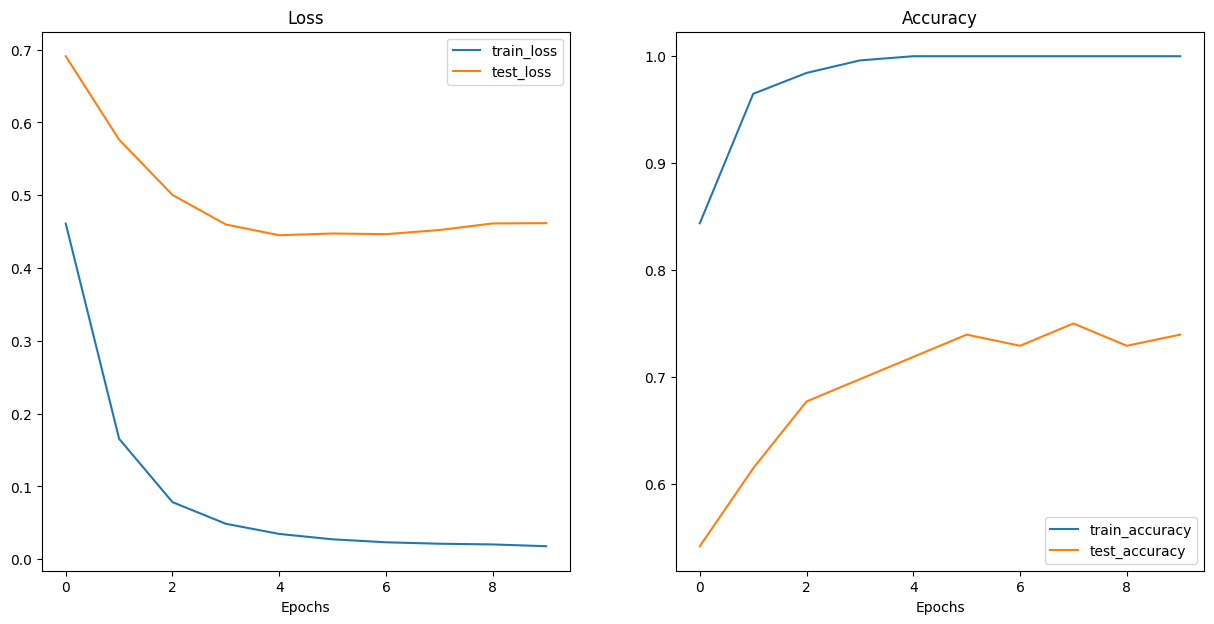

In [63]:
plot_loss_curves(pretrain_results)

# Training and testing the new data ( Tuborculosis and normal chest images data)

In [64]:
data_pretrained = ImageFolder(root="/content/drive/MyDrive/Project data", transform=vit_transforms)
data_len = len(data_pretrained)
# small_data_len = data_len - int(0.70 * data_len)
# print(small_data_len)
n_test = int(0.30 * data_len)
print(n_test)
test_data = Subset(data_pretrained, range(n_test))
train_data = Subset(data_pretrained, range(n_test, data_len))

import os
from torch.utils.data import DataLoader
BATCH_SIZE = 32
NUM_WORKERS = 8
train_dataloader = DataLoader(dataset=train_data,
                              batch_size=BATCH_SIZE,
                              shuffle=True,
                              num_workers=NUM_WORKERS,
                              drop_last=True)

test_dataloader = DataLoader(dataset=test_data,
                             batch_size=BATCH_SIZE,
                             num_workers=NUM_WORKERS,
                             drop_last=True)
class_names = data_pretrained.classes

len(train_dataloader), len(test_dataloader), class_names

270


(19, 8, ['Normal', 'Tuberculosis'])

In [65]:
pretrain_optimizer = torch.optim.Adam(params=pretrained_vit.parameters(),
                             lr=0.001,
                             betas=(0.9, 0.999),
                             weight_decay=0.1)


In [66]:
pretrain_results = train(model=pretrained_vit,
                         train_dataloader=train_dataloader,
                         test_dataloader=test_dataloader,
                         loss_fn=loss_fn,
                         optimizer=pretrain_optimizer,
                         epochs=10)
pretrain_results

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 0 | Train Loss: 0.53233 | Train Accuracy: 0.73% | Test Loss: 0.20464 | Test Accuracy: 0.97%
Epoch: 1 | Train Loss: 0.28559 | Train Accuracy: 0.88% | Test Loss: 0.21718 | Test Accuracy: 0.93%
Epoch: 2 | Train Loss: 0.23044 | Train Accuracy: 0.92% | Test Loss: 0.14509 | Test Accuracy: 0.97%
Epoch: 3 | Train Loss: 0.19383 | Train Accuracy: 0.93% | Test Loss: 0.23201 | Test Accuracy: 0.93%
Epoch: 4 | Train Loss: 0.17697 | Train Accuracy: 0.94% | Test Loss: 0.13934 | Test Accuracy: 0.97%
Epoch: 5 | Train Loss: 0.15811 | Train Accuracy: 0.95% | Test Loss: 0.17534 | Test Accuracy: 0.95%
Epoch: 6 | Train Loss: 0.14356 | Train Accuracy: 0.96% | Test Loss: 0.10184 | Test Accuracy: 0.98%
Epoch: 7 | Train Loss: 0.14015 | Train Accuracy: 0.96% | Test Loss: 0.07903 | Test Accuracy: 1.00%
Epoch: 8 | Train Loss: 0.13169 | Train Accuracy: 0.96% | Test Loss: 0.12832 | Test Accuracy: 0.97%
Epoch: 9 | Train Loss: 0.11688 | Train Accuracy: 0.97% | Test Loss: 0.10683 | Test Accuracy: 0.98%


{'train_loss': [0.5323311968853599,
  0.2855916407547499,
  0.2304437152649227,
  0.1938344906819494,
  0.1769706508830974,
  0.15811137227635635,
  0.1435623702250029,
  0.1401521857631834,
  0.13169129408503832,
  0.1168801074749545],
 'train_acc': [tensor(0.7286, device='cuda:0'),
  tensor(0.8799, device='cuda:0'),
  tensor(0.9178, device='cuda:0'),
  tensor(0.9293, device='cuda:0'),
  tensor(0.9424, device='cuda:0'),
  tensor(0.9490, device='cuda:0'),
  tensor(0.9622, device='cuda:0'),
  tensor(0.9572, device='cuda:0'),
  tensor(0.9605, device='cuda:0'),
  tensor(0.9737, device='cuda:0')],
 'test_loss': [0.20463687926530838,
  0.21718295849859715,
  0.1450871927663684,
  0.23201094381511211,
  0.1393394796177745,
  0.17533777095377445,
  0.10183832980692387,
  0.07903386652469635,
  0.1283235950395465,
  0.1068274499848485],
 'test_acc': [tensor(0.9688, device='cuda:0'),
  tensor(0.9297, device='cuda:0'),
  tensor(0.9727, device='cuda:0'),
  tensor(0.9258, device='cuda:0'),
  tenso

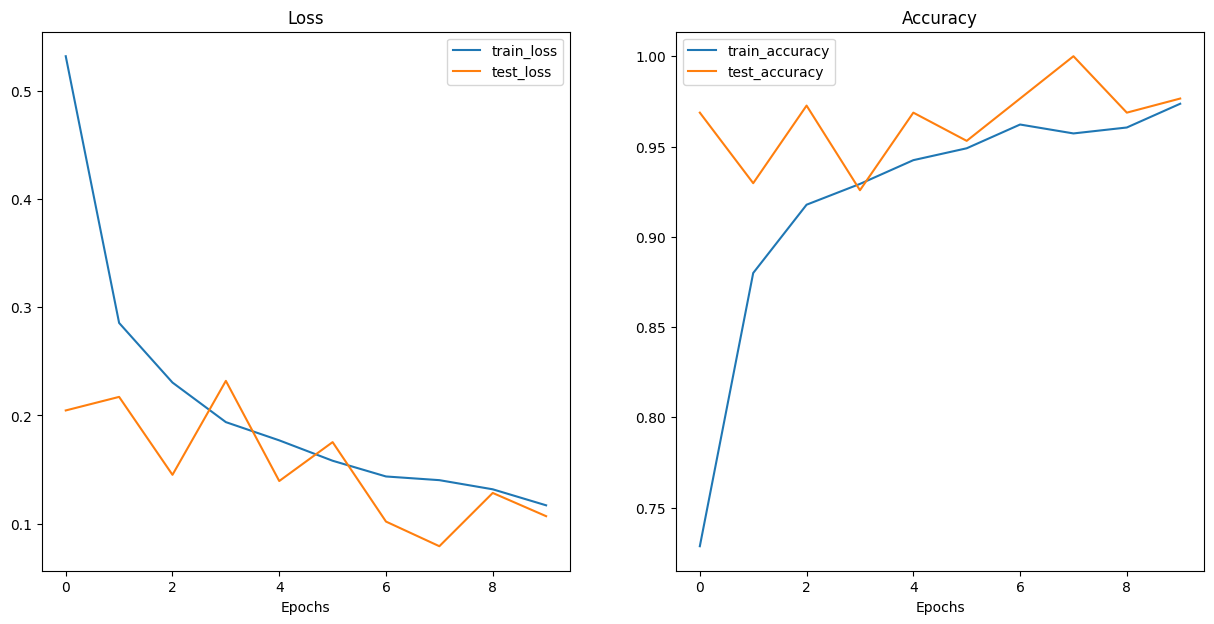

In [67]:
plot_loss_curves(pretrain_results)

In [72]:
import pickle

# Save the model using pickle
with open('pretrained_vit_model.pkl', 'wb') as f:
    pickle.dump(pretrained_vit, f)

In [70]:
save_path=('/content/model_saved')
torch.save({
    'model_state_dict': pretrained_vit.state_dict(),
    'optimizer_state_dict': pretrain_optimizer.state_dict()
}, save_path)

In [71]:
torch.save(pretrained_vit, '/content/my_model')

In [73]:
import joblib

In [74]:
joblib.dump(pretrained_vit,'/content/model_joblib')

['/content/model_joblib']